# <center>7. PortPy 3D Slicer Integration </center>

### This example demonstrates performing the following tasks using portpy:

1. Query the existing patients in the database
    (you first need to download the patient database from the link provided in the GitHub page).
2. Create a simple IMRT plan using CVXPy package. You can call different opensource/commercial optimization engines
    from CVXPy,but you first need to download them and obtain an appropriate license.
    Most commercial optimization engines (e.g., Mosek, Gorubi) give free academic license if you have .edu email
    address
3. Visualise the plan using 3d slicer

**Note: Please install 3d slicer and slicer jupyter extension as metioned in https://github.com/Slicer/SlicerJupyter before running this notebook. Change the kernel to Slicer kernel once the installation is complete


In [2]:
import sys
sys.path.append('..')

In [14]:
import portpy.photon as pp

In [5]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# display the existing patients in console or browser.
data.display_list_of_patients()

+----+------------------------+----------------+--------------+-------------+
|    | patient_id             | disease_site   |   ptv_vol_cc |   num_beams |
|----+------------------------+----------------+--------------+-------------|
|  0 | Lung_Patient_2         | Lung           |     737.229  |          72 |
|  1 | Lung_Phantom_Patient_1 | Lung           |      43.9018 |          72 |
|  2 | Lung_Phantom_Patient_3 | Lung           |      49.425  |          72 |
+----+------------------------+----------------+--------------+-------------+


In [6]:
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, )
patient_id = 'Lung_Patient_2'
data.patient_id = patient_id

In [7]:
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params=opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


### 2) Creating a simple IMRT plan using CVXPy (Plan class, Optimization class)
Note: you can call different opensource / commercial optimization engines from CVXPy.
  For commercial engines (e.g., Mosek, Gorubi, CPLEX), you first need to obtain an appropriate license.
  Most commercial optimization engines give free academic license.

Create my_plan object which would store all the data needed for optimization
  (e.g., influence matrix, structures and their voxels, beams and their beamlets).

In [8]:
# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()

Objective Start
Objective done
Constraints Start
Constraints done


### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation


$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x} \geq 0
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [9]:
# run optimization
sol = opt.solve(solver='MOSEK', verbose=False)

<Axes: xlabel='Dose (Gy)', ylabel='Volume Fraction (%)'>

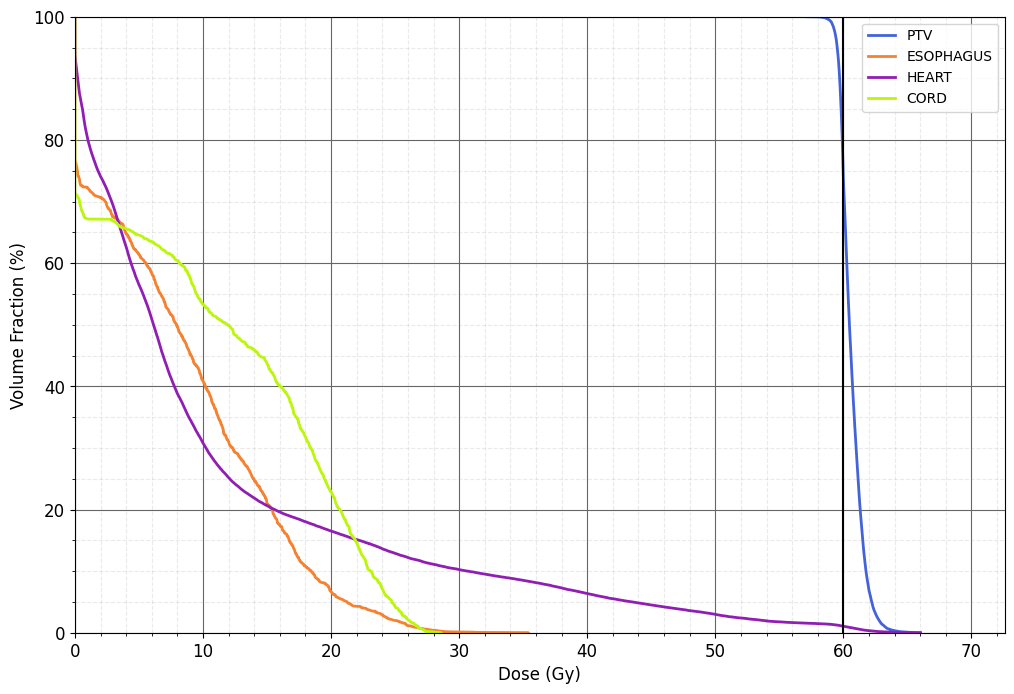

In [10]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names)

In [11]:
dose_1d = sol['inf_matrix'].A * sol['optimal_intensity']*my_plan.get_num_of_fractions()
dose_arr = sol['inf_matrix'].dose_1d_to_3d(dose_1d=dose_1d)

### 3) Visualize using Slicer Jupyter

In [15]:
pp.view_in_slicer_jupyter(my_plan, sol=sol)

Importing struct_name : GTV
Importing struct_name : PTV
Importing struct_name : ESOPHAGUS
Importing struct_name : HEART
Importing struct_name : LUNG_L
Importing struct_name : LUNG_R
Importing struct_name : CORD
Importing struct_name : SKIN
Importing struct_name : RIND_0
Importing struct_name : RIND_1
Importing struct_name : RIND_2
Importing struct_name : RIND_3
Importing struct_name : RIND_4


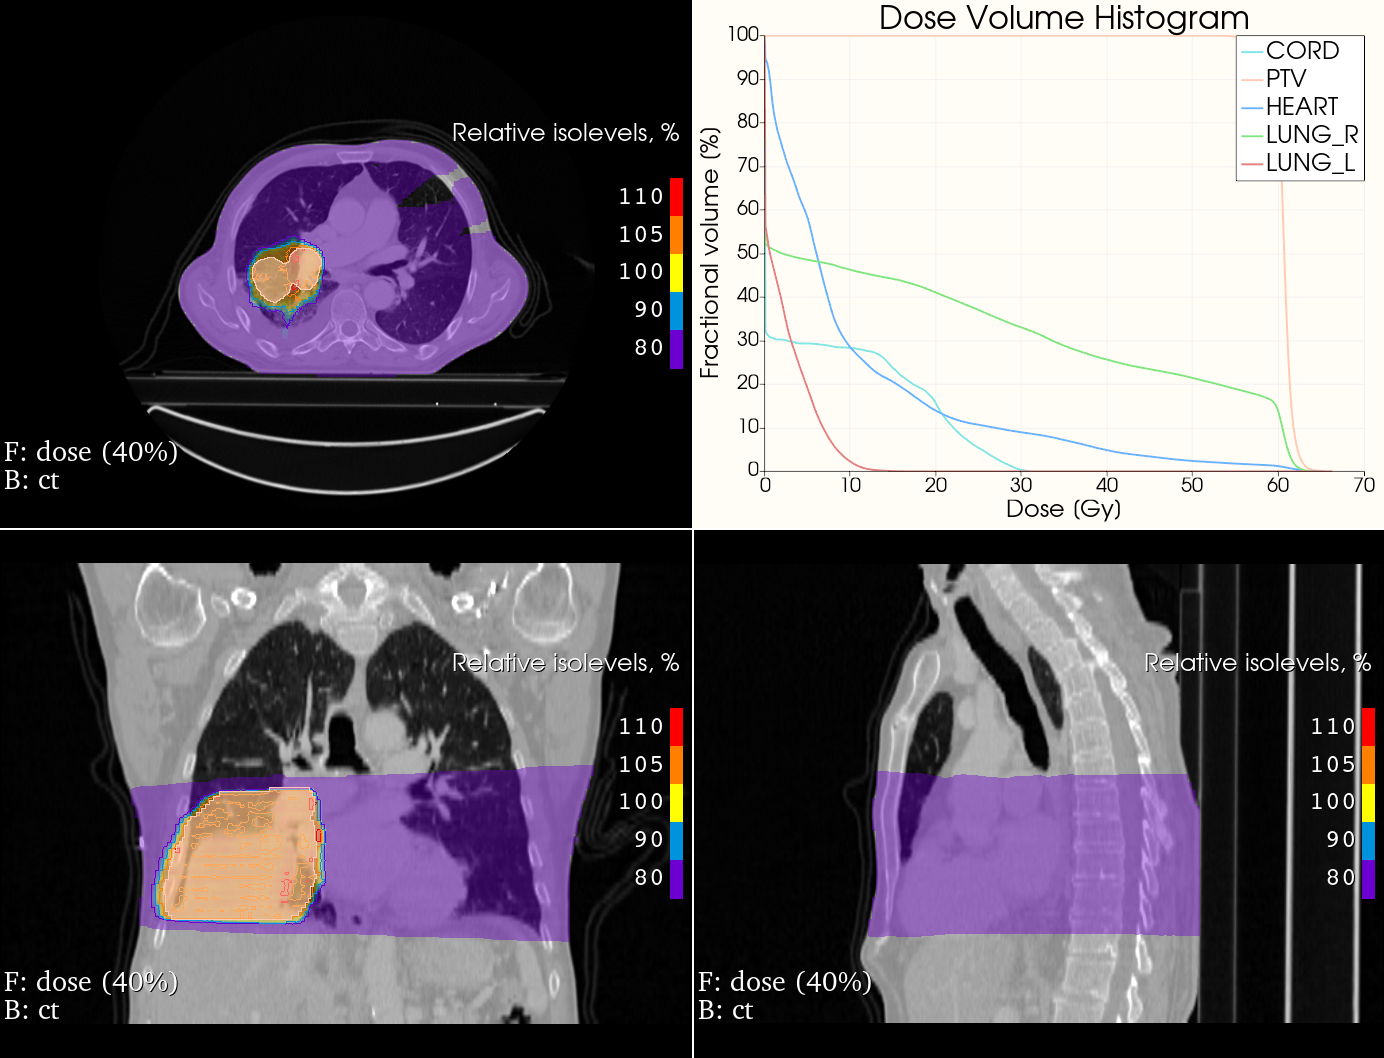

In [12]:
import JupyterNotebooksLib as slicernb
slicernb.ViewDisplay()